In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        pass
#         print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [2]:
import tensorflow as tf
from tensorflow.keras.models import Sequential

device_name = tf.test.gpu_device_name()
if device_name != '/device:GPU:0':
    raise SystemError('GPU device not found')
print('Found GPU at: {}'.format(device_name))

Found GPU at: /device:GPU:0


In [3]:
tf.executing_eagerly()

True

In [4]:
from __future__ import absolute_import, division, print_function, unicode_literals
import numpy as np
import matplotlib.pyplot as plt
import cv2

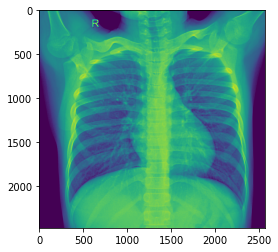

In [5]:
plt.imshow(plt.imread("/kaggle/input/labeled-chest-xray-images/chest_xray/train/NORMAL/NORMAL-1003233-0001.jpeg"))

In [6]:
plt.imread("/kaggle/input/labeled-chest-xray-images/chest_xray/train/NORMAL/NORMAL-1003233-0001.jpeg").shape

(2476, 2572)

## Dataset Loading

In [7]:
image_generator = tf.keras.preprocessing.image.ImageDataGenerator(
      rescale=1./255,
      horizontal_flip = False,
      vertical_flip = False)

BATCH_SIZE = 5
IMG_WIDTH = 500 # Change this 
IMG_HEIGHT = IMG_WIDTH* 1858 // 2090

train_data_gen = image_generator.flow_from_directory(directory="/kaggle/input/labeled-chest-xray-images/chest_xray/train/",
                                                     batch_size=BATCH_SIZE,
                                                     shuffle=True,  
                                                     target_size=(IMG_HEIGHT, IMG_WIDTH),
                                                     class_mode = 'binary',
                                                     interpolation = 'bilinear',
                                                     color_mode = "grayscale")
                                                
test_data_gen = image_generator.flow_from_directory(directory="/kaggle/input/labeled-chest-xray-images/chest_xray/test/",
                                                     batch_size=BATCH_SIZE,
                                                     shuffle=True,
                                                     target_size=(IMG_HEIGHT, IMG_WIDTH),
                                                     class_mode = 'binary',
                                                     interpolation = 'bilinear',
                                                     color_mode = "grayscale")

Found 5232 images belonging to 2 classes.
Found 624 images belonging to 2 classes.


1.0


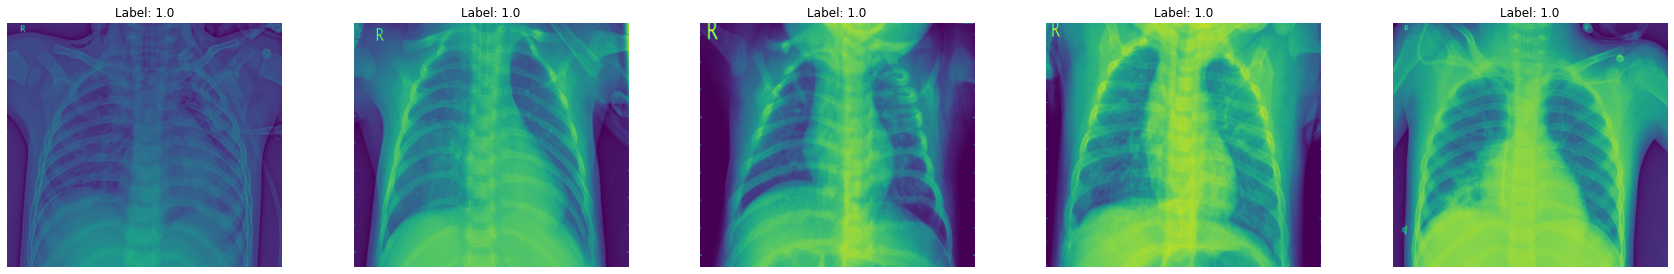

In [8]:
def show_batch(image_batch, label_batch):
    plt.figure(figsize=(30,30* 1858 // 2090))
    for n in range(5):
        ax = plt.subplot(5,5,n+1)
        plt.imshow(image_batch[n])#.reshape(399, 227))
        plt.title("Label: " + str(label_batch[n]))
        plt.axis('off')
        
image_batch, label_batch = next(train_data_gen)
show_batch(image_batch, label_batch)
print (np.mean(label_batch))

In [9]:
from tensorflow.keras import layers

model = tf.keras.Sequential([
    layers.Conv2D(64, (3, 3), activation='relu', input_shape=(IMG_HEIGHT, IMG_WIDTH, 1)),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(32, (3, 3), activation='relu'),
    layers.Flatten(),
    layers.Dense(500, activation='relu'),
    layers.Dense(1, activation='sigmoid')
])

model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 442, 498, 64)      640       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 221, 249, 64)      0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 219, 247, 64)      36928     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 109, 123, 64)      0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 107, 121, 64)      36928     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 53, 60, 64)        0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 51, 58, 64)        3

In [18]:
from tensorflow.keras import optimizers
from tensorflow.keras.callbacks import ModelCheckpoint

accuracy_threshold = tf.keras.metrics.BinaryAccuracy(name='binary_accuracy', 
                                                     threshold = 3883/(3883+1349)) #0.74216360856

model.compile(optimizer= 'adam',
              loss='binary_crossentropy',
              metrics=[accuracy_threshold])#['accuracy'])

filepath="/kaggle/working/CNN-improvement-{val_binary_accuracy:.2f}.hdf5"
checkpoint = ModelCheckpoint(filepath, monitor='val_binary_accuracy', verbose=1, save_best_only=True, mode='max')
earlyStop = tf.keras.callbacks.EarlyStopping(monitor='val_binary_accuracy', patience=30)

In [19]:
 history = model.fit_generator(
        train_data_gen,
        steps_per_epoch=1600 // BATCH_SIZE,
        epochs=100,
        callbacks= [earlyStop, checkpoint],
        validation_data = test_data_gen,
        validation_steps=400 // BATCH_SIZE,
        workers = 16, verbose  =1
        )

Epoch 1/100
320/320 [==============================] - 27s 81ms/step - loss: 0.2148 - binary_accuracy: 0.8994 - val_loss: 0.3581 - val_binary_accuracy: 0.8675

Epoch 00001: val_binary_accuracy improved from -inf to 0.86750, saving model to /kaggle/working/CNN-improvement-0.87.hdf5
Epoch 2/100
320/320 [==============================] - 27s 83ms/step - loss: 0.1560 - binary_accuracy: 0.9396 - val_loss: 0.5966 - val_binary_accuracy: 0.8650

Epoch 00002: val_binary_accuracy did not improve from 0.86750
Epoch 3/100
320/320 [==============================] - 27s 84ms/step - loss: 0.1432 - binary_accuracy: 0.9406 - val_loss: 0.5779 - val_binary_accuracy: 0.8650

Epoch 00003: val_binary_accuracy did not improve from 0.86750
Epoch 4/100
320/320 [==============================] - 27s 83ms/step - loss: 0.0922 - binary_accuracy: 0.9573 - val_loss: 0.4711 - val_binary_accuracy: 0.8750

Epoch 00004: val_binary_accuracy improved from 0.86750 to 0.87500, saving model to /kaggle/working/CNN-improvement

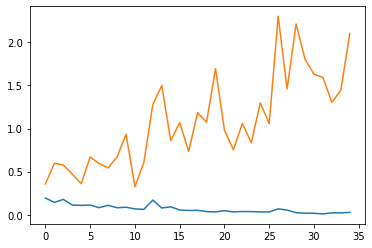

In [20]:
plt.plot(history.epoch, history.history['loss'])
plt.plot(history.epoch, history.history['val_loss'])

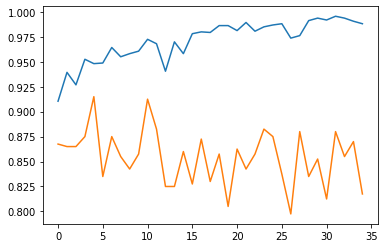

In [22]:
plt.plot(history.epoch, history.history['binary_accuracy'])
plt.plot(history.epoch, history.history['val_binary_accuracy'])

In [25]:
model = tf.keras.models.load_model("./CNN-improvement-0.92.hdf5")

In [26]:
model.evaluate(train_data_gen, verbose = 1)

1047/1047 [==============================] - 78s 74ms/step - loss: 0.1357 - binary_accuracy: 0.9148


[0.13568516075611115, 0.9147553443908691]

In [27]:
model.evaluate(test_data_gen, verbose = 1)

125/125 [==============================] - 9s 72ms/step - loss: 0.4062 - binary_accuracy: 0.9071


[0.40623971819877625, 0.9070512652397156]